# DT2470 Lab 04: Shazam Wow!

by Bob L. T. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

![uc-1.png](attachment:uc-1.png)

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

# Part 1: Creating audio fingerprints

## 1.1 

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


In [ ]:
# add your code below
%pip install pydub 
%pip install playsound

import pydub
import matplotlib.pyplot as plt
import numpy as np
import os
from pydub import AudioSegment
from scipy import signal
from scipy.fft import rfft, rfftfreq

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Dataset/queries.zip'

In [ ]:
import IPython
cwd = os.getcwd()
query_path = os.path.join(cwd,"queries/Q1.wav")
IPython.display.Audio(query_path)


In [ ]:
def ms_to_samples(time, F_s):
  return (time/1000)*F_s

def get_sonogram(query='Q1.wav', duration=10):

  wav_audio = AudioSegment.from_file('/content/queries/{}'.format(query), format="wav",duration=duration)
  sound = wav_audio.split_to_mono()[0].get_array_of_samples()
  sound_n = np.multiply(sound,1/max(max(sound), np.abs(min(sound))))

  frames_per_second = wav_audio.frame_rate
  nperseg = ms_to_samples(50, frames_per_second)
  noverlap = ms_to_samples(40, frames_per_second)
  # hop size = nperseg - noverlap
  f1, t1, yf1 = signal.stft(sound_n, fs=frames_per_second,window='hann',
                            nperseg=nperseg, noverlap=noverlap, nfft = 4*nperseg)
  yf1_db = np.multiply(20,np.log10(np.abs(yf1)/np.max(np.abs(yf1))))

  return t1, f1, yf1, yf1_db, frames_per_second

def plot_sonogram(t, f, yf_db):
  fig = plt.figure()
  c1 = plt.pcolormesh(t, f/1000, yf_db, shading='gouraud', cmap='magma', vmin = -80)
  plt.colorbar(c1, format='%+2.0f dB')
  plt.title('STFT Magnitude [dB] - 50 ms duration, 10 ms hop size')
  plt.ylabel('Frequency [kHz]')
  plt.xlabel('Time [s]')
  plt.ylim([0, 5])

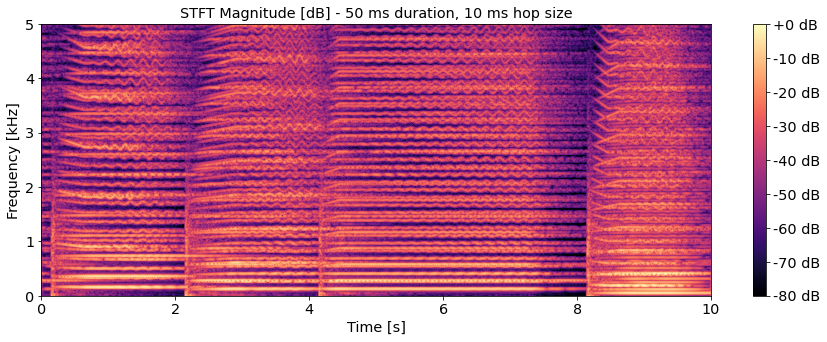

In [ ]:
t1, f1, yf1, yf1_db, fs = get_sonogram(query='Q1.wav', duration=10)

plot_sonogram(t1, f1, yf1_db)

# 1.2 

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [ ]:
# add your code below
def calc_anchors(yf, yf_db, t1, f1):
  delta_t = 10
  delta_f = int(len(f1)/25)
  f_max, t_max, db_max = [], [], []

  for f in range(0,len(f1)-1, delta_f):
    for t in range(0, len(t1)-1, delta_t):
      y_slice = yf[f:f+delta_f, t:t+delta_t]
      f_val = np.amax(y_slice)
      result = np.where(y_slice == f_val)
      f_coord, t_coord = f+result[0][0], t+result[1][0]
      f_max.append(f1[f_coord])
      t_max.append(t1[t_coord])
      db_max.append(yf_db[f_coord, t_coord])

  return t_max, f_max, db_max


3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x".

**Comment on anchors over sonogram: High energy --> high decibel, i.e. the anchors are located on the segments with the highest dB in the sonogram.**

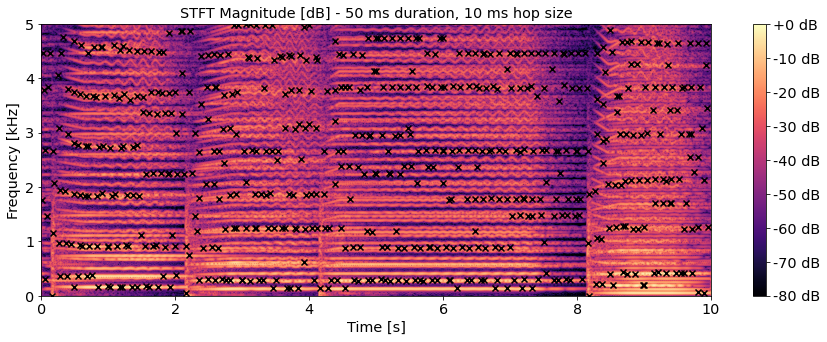

In [ ]:
# add your code below
time_anchors, freq_anchors, db_anchors = calc_anchors(yf1, yf1_db, t1, f1)

plot_sonogram(t1, f1, yf1_db)
plt.scatter(time_anchors, np.multiply(freq_anchors,  1/1000), color='black', marker = 'x', linewidths = 0.75)


## 1.3

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [ ]:
# add your code below
def create_fingerprint(time_anchor_list, freq_anchor_list):

  F = []
  for cnt, (time, fr) in enumerate(zip(time_anchor_list, freq_anchor_list)):
    time_floor, time_ceil = time + 0.1, time + 0.6
    freq_floor, freq_ceil = fr/np.sqrt(2), fr*np.sqrt(2)

    time_target_zone = time_anchor_list[cnt+1:cnt+7]
    freq_target_zone = freq_anchor_list[cnt+1:cnt+7]

    t_in_range = np.where((time_target_zone >= time_floor), time_target_zone, -1)
    t_in_range = np.where((t_in_range <= time_ceil), t_in_range, -1)

    f_in_range = np.where((freq_target_zone >= freq_floor), freq_target_zone, -1)
    f_in_range = np.where((f_in_range <= freq_ceil), f_in_range, -1)

    target_zone = [i for i in range(len(f_in_range)) if (t_in_range[i] > -1 and f_in_range[i] > -1)]

    for j in target_zone:
      F.append((time, [fr, f_in_range[j], t_in_range[j]-time]))

  return F

In [ ]:
F = create_fingerprint(time_anchors, freq_anchors)

# Part 2: Comparing fingerprints

## 2.1 

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this: 

![matches.png](attachment:matches.png)



In [ ]:
def compare_fingerprints(F1, F2):
  t1, t2 = [], []
  for f1 in F1:
    for f2 in F2:
      diff = abs(np.subtract(f1[1], f2[1]))
      diff = (diff == 0)
      if False not in diff:
        t1.append(f1[0])
        t2.append(f2[0])

  return t1, t2

In [ ]:
# add your code below
t2, f2, yf2, yf2_db, fs = get_sonogram(query='Q1.wav', duration=1)
time_anchors2, freq_anchors2, db_anchors2 = calc_anchors(yf2, yf2_db, t2, f2)
F_q = create_fingerprint(time_anchors2, freq_anchors2)
t_F_q1, t_F_q2 = compare_fingerprints(F_q, F_q)


Text(0.5, 1.0, 'Fingerprint match for F_q with itself')

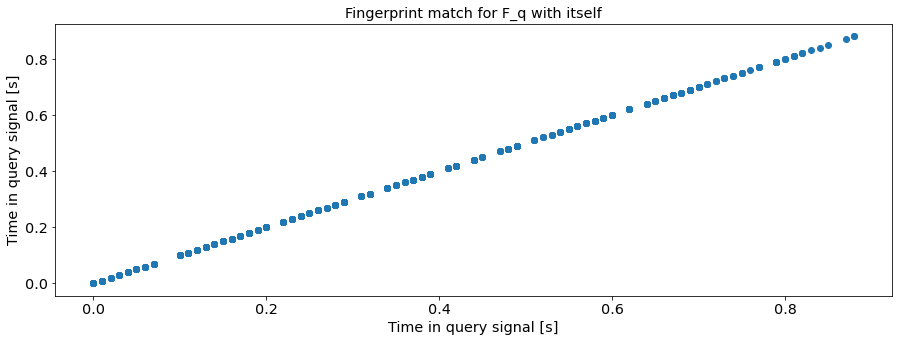

In [ ]:
plt.scatter(t_F_q1, t_F_q2)
plt.xlabel("Time in query signal [s]")
plt.ylabel("Time in query signal [s]")
plt.title("Fingerprint match for F_q with itself")

**Comment on fingerprint match with itself: What we observe is matches on the diagonal. Naturally, when matching a sample with itself the hashes will match with the same time stamp in both inputs to the matching algorithm.**

## 2.2 

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

In [ ]:
# add your code below
t_F, t_F_q = compare_fingerprints(F, F_q)

Text(0.5, 1.0, 'Fingerprint match for 1 s segment with full document')

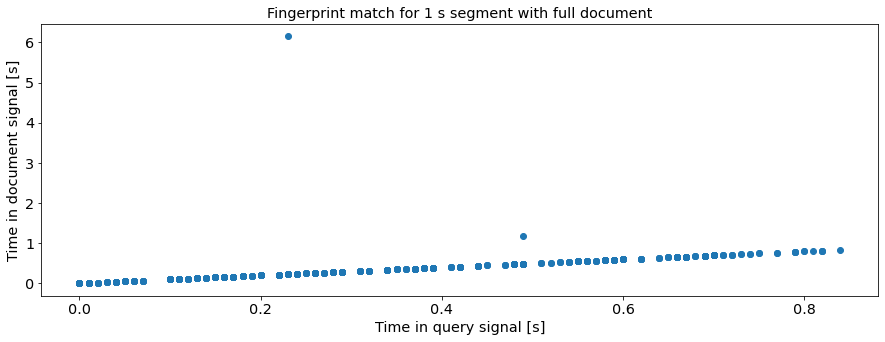

In [ ]:
plt.scatter(t_F_q,t_F)
plt.xlabel("Time in query signal [s]")
plt.ylabel("Time in document signal [s]")
plt.title("Fingerprint match for 1 s segment with full document")

**Comment on query fingerprint match with whole document fingerprint: again we see the matches on the diagonal of one second of the whole document, the part we sliced off. We also see two matches not on that diagonal which means that we found a similar pattern in the 9 seconds after the 1 second excerpt.**

## 2.3 

Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

In [ ]:
# add your code below
t3, f3, yf3, yf3_db, fs = get_sonogram(query='Q2.wav', duration=10)
time_anchors3, freq_anchors3, db_anchors3 = calc_anchors(yf3, yf3_db, t3, f3)
F_d = create_fingerprint(time_anchors3, freq_anchors3)
t_F_q3, t_F_d = compare_fingerprints(F_q, F_d)


Text(0.5, 1.0, 'Fingerprint match for 1 s segment with full document')

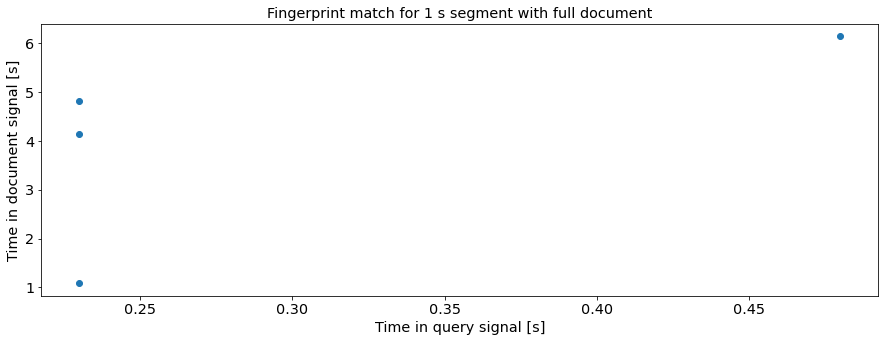

In [ ]:
plt.scatter(t_F_q3, t_F_d)
plt.xlabel("Time in query signal [s]")
plt.ylabel("Time in document signal [s]")
plt.title("Fingerprint match for 1 s segment with full document")

**Comment on fingerprint match with a different document: as expected far fewer matches. We cannot see that distinct pattern we saw in the previous plot. All these matches really tells us is that there was the exact frequency change over the same time difference in both samples. Maybe such a pattern is common in a certain genre and thus we are more likely to find some matches in audio of the same genre.**

# *2.4

Here's a project idea: Write a program to locate the files in the kiki-bouba collection from which all these queries come.